## 1. Winter is Coming. Let's load the dataset ASAP!
<p>If you haven't heard of <em>Game of Thrones</em>, then you must be really good at hiding. Game of Thrones is the hugely popular television series by HBO based on the (also) hugely popular book series <em>A Song of Ice and Fire</em> by George R.R. Martin. In this notebook, we will analyze the co-occurrence network of the characters in the  Game of Thrones books. Here, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books. </p>
<p><img src="https://assets.datacamp.com/production/project_76/img/got_network.jpeg" style="width: 550px"></p>
<p>This dataset constitutes a network and is given as a text file describing the <em>edges</em> between characters, with some attributes attached to each edge. Let's start by loading in the data for the first book <em>A Game of Thrones</em> and inspect it.</p>

In [21]:
import pandas as pd

book1 = pd.read_csv("datasets/book1.csv")
print(book1.head(5))

                            Source              Target        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   

   book  
0     1  
1     1  
2     1  
3     1  
4     1  


## 2. Time for some Network of Thrones
<p>The resulting DataFrame <code>book1</code> has 5 columns: <code>Source</code>, <code>Target</code>, <code>Type</code>, <code>weight</code>, and <code>book</code>. Source and target are the two nodes that are linked by an edge. A network can have directed or undirected edges and in this network all the edges are undirected. The weight attribute of every edge tells us the number of interactions that the characters have had over the book, and the book column tells us the book number.</p>
<p>Once we have the data loaded as a pandas DataFrame, it's time to create a network. We will use <code>networkx</code>, a network analysis library, and create a graph object for the first book.</p>

In [23]:
import networkx as nx

G_book1 = nx.Graph()

## 3. Populate the network with the DataFrame
<p>Currently, the graph object <code>G_book1</code> is empty. Let's now populate it with the edges from <code>book1</code>. And while we're at it, let's load in the rest of the books too!</p>

In [25]:
for _, edge in book1.iterrows():
    G_book1.add_edge(edge["Source"], edge["Target"], weight=edge["weight"])

# Creating a list of networks for all the books
books = [G_book1]
book_fnames = ["datasets/book2.csv", "datasets/book3.csv", "datasets/book4.csv", "datasets/book5.csv"]
for book_fname in book_fnames:
    book = pd.read_csv(book_fname)
    G_book = nx.Graph()
    for _, edge in book.iterrows():
        G_book.add_edge(edge["Source"], edge["Target"], weight=edge["weight"])
    books.append(G_book)

## 4. The most important character in Game of Thrones
<p>Is it Jon Snow, Tyrion, Daenerys, or someone else? Let's see! Network science offers us many different metrics to measure the importance of a node in a network. Note that there is no "correct" way of calculating the most important node in a network, every metric has a different meaning.</p>
<p>First, let's measure the importance of a node in a network by looking at the number of neighbors it has, that is, the number of nodes it is connected to. For example, an influential account on Twitter, where the follower-followee relationship forms the network, is an account which has a high number of followers. This measure of importance is called <em>degree centrality</em>.</p>
<p>Using this measure, let's extract the top ten important characters from the first book (<code>book[0]</code>) and the fifth book (<code>book[4]</code>).</p>

In [27]:
deg_cen_book1 = nx.degree_centrality(books[0])
deg_cen_book5 = nx.degree_centrality(books[4])

sorted_deg_cen_book1 = sorted(deg_cen_book1.items(), key=lambda x:x[1], reverse=True)[0:10]
sorted_deg_cen_book5 = sorted(deg_cen_book5.items(), key=lambda x:x[1], reverse=True)[0:10]

print(sorted_deg_cen_book1)
print(sorted_deg_cen_book5)

[('Eddard-Stark', 0.3548387096774194), ('Robert-Baratheon', 0.2688172043010753), ('Tyrion-Lannister', 0.24731182795698928), ('Catelyn-Stark', 0.23118279569892475), ('Jon-Snow', 0.19892473118279572), ('Robb-Stark', 0.18817204301075272), ('Sansa-Stark', 0.18817204301075272), ('Bran-Stark', 0.17204301075268819), ('Cersei-Lannister', 0.16129032258064518), ('Joffrey-Baratheon', 0.16129032258064518)]
[('Jon-Snow', 0.1962025316455696), ('Daenerys-Targaryen', 0.18354430379746836), ('Stannis-Baratheon', 0.14873417721518986), ('Tyrion-Lannister', 0.10443037974683544), ('Theon-Greyjoy', 0.10443037974683544), ('Cersei-Lannister', 0.08860759493670886), ('Barristan-Selmy', 0.07911392405063292), ('Hizdahr-zo-Loraq', 0.06962025316455696), ('Asha-Greyjoy', 0.056962025316455694), ('Melisandre', 0.05379746835443038)]


## 5. The evolution of character importance
<p>According to degree centrality, the most important character in the first book is Eddard Stark but he is not even in the top 10 of the fifth book. The importance of characters changes over the course of five books because, you know, stuff happens… ;)</p>
<p>Let's look at the evolution of degree centrality of a couple of characters like Eddard Stark, Jon Snow, and Tyrion, which showed up in the top 10 of degree centrality in the first book.</p>

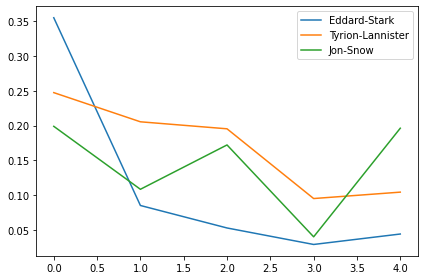

In [29]:
%matplotlib inline

evol = [nx.degree_centrality(book) for book in books]
 
# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)
degree_evol_df[["Eddard-Stark", "Tyrion-Lannister", "Jon-Snow"]].plot()

## 6. What's up with Stannis Baratheon?
<p>We can see that the importance of Eddard Stark dies off as the book series progresses. With Jon Snow, there is a drop in the fourth book but a sudden rise in the fifth book.</p>
<p>Now let's look at various other measures like <em>betweenness centrality</em> and <em>PageRank</em> to find important characters in our Game of Thrones character co-occurrence network and see if we can uncover some more interesting facts about this network. Let's plot the evolution of betweenness centrality of this network over the five books. We will take the evolution of the top four characters of every book and plot it.</p>

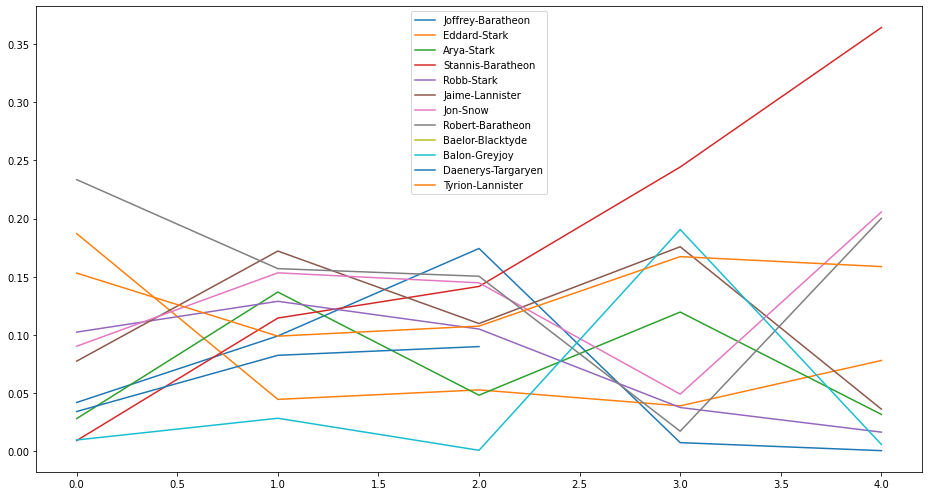

In [31]:
evol = [nx.betweenness_centrality(book, weight='weight') for book in books]

# Making a DataFrame from the list
betweenness_evol_df = pd.DataFrame.from_records(evol)

set_of_char = set()
for i in range(5):
    set_of_char |= set(list(betweenness_evol_df.T[i].sort_values(ascending=False)[0:4].index))
list_of_char = list(set_of_char)

betweenness_evol_df[list_of_char].plot(figsize=(13, 7))

## 7. What does Google PageRank tell us about GoT?
<p>We see a peculiar rise in the importance of Stannis Baratheon over the books. In the fifth book, he is significantly more important than other characters in the network, even though he is the third most important character according to degree centrality.</p>
<p>PageRank was the initial way Google ranked web pages. It evaluates the inlinks and outlinks of webpages in the world wide web, which is, essentially, a directed network. Let's look at the importance of characters in the Game of Thrones network according to PageRank. </p>

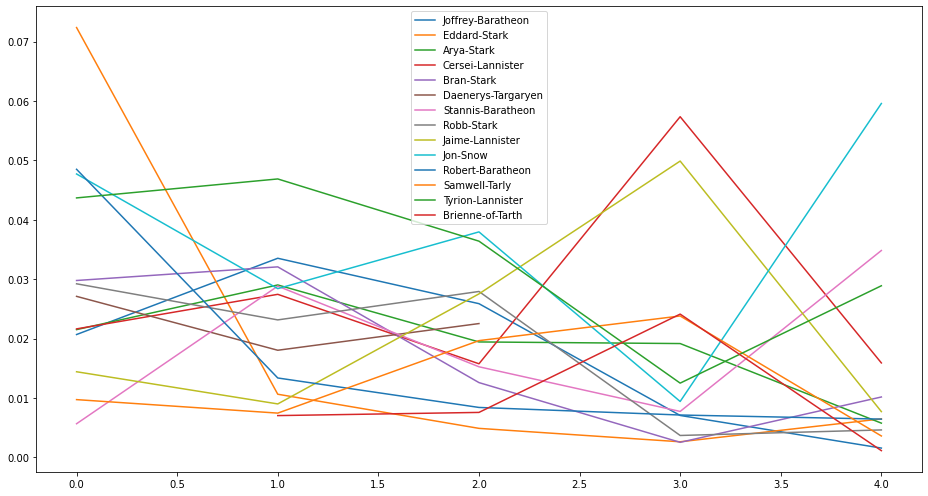

In [33]:
evol = [nx.pagerank(book) for book in books]
pagerank_evol_df = pd.DataFrame.from_records(evol)

set_of_char = set()
for i in range(5):
    set_of_char |= set(list(pagerank_evol_df.T[i].sort_values(ascending=False)[0:4].index))
list_of_char = list(set_of_char)

pagerank_evol_df[list_of_char].plot(figsize=(13, 7))

## 8. Correlation between different measures
<p>Stannis, Jon Snow, and Daenerys are the most important characters in the fifth book according to PageRank. Eddard Stark follows a similar curve but for degree centrality and betweenness centrality: He is important in the first book but dies into oblivion over the book series.</p>
<p>We have seen three different measures to calculate the importance of a node in a network, and all of them tells us something about the characters and their importance in the co-occurrence network. We see some names pop up in all three measures so maybe there is a strong correlation between them?</p>
<p>Let's look at the correlation between PageRank, betweenness centrality and degree centrality for the fifth book using Pearson correlation.</p>

In [35]:
measures = [nx.pagerank(books[4]), 
            nx.betweenness_centrality(books[4], weight='weight'), 
            nx.degree_centrality(books[4])]

cor = pd.DataFrame.from_records(measures)
cor.corr()

,Aegon-I-Targaryen,Daenerys-Targaryen,Aegon-Targaryen-(son-of-Rhaegar),Elia-Martell,Franklyn-Flowers,Haldon,Harry-Strickland,Jon-Connington,Lemore,Rhaegar-Targaryen,...,Tysha,Shrouded-Lord,Theomore,William-Foxglove,Walder-Frey-(son-of-Jammos),Wex-Pyke,Willow-Witch-eye,Thistle,Wylis-Manderly,Wulfe
Aegon-I-Targaryen,1.000000,-0.018377,0.278893,0.675768,0.647014,0.918495,0.999852,0.836828,0.995226,0.753194,...,0.312087,0.999997,-0.578654,1.000000,0.997255,1.000000,0.999742,0.923316,0.999994,0.999190
Daenerys-Targaryen,-0.018377,1.000000,0.955035,0.724571,0.750459,0.378486,-0.035547,0.531994,0.079287,0.643845,...,0.944158,-0.020834,0.826070,-0.019232,-0.092358,-0.018104,-0.041092,-0.400943,-0.021945,-0.058597
Aegon-Targaryen-(son-of-Rhaegar),0.278893,0.955035,1.000000,0.896334,0.912672,0.635904,0.262358,0.759128,0.371282,0.841758,...,0.999396,0.276532,0.621831,0.278072,0.207021,0.279155,0.256999,-0.111296,0.275465,0.240022
Elia-Martell,0.675768,0.724571,0.896334,1.000000,0.999265,0.912169,0.663009,0.969047,0.744480,0.993857,...,0.911196,0.673955,0.210135,0.675138,0.619335,0.675970,0.658844,0.340867,0.673134,0.645559
Franklyn-Flowers,0.647014,0.750459,0.912672,0.999265,1.000000,0.895787,0.633823,0.958870,0.718338,0.988884,...,0.926320,0.645138,0.247460,0.646362,0.588781,0.647222,0.629521,0.304576,0.644289,0.615806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wex-Pyke,1.000000,-0.018104,0.279155,0.675970,0.647222,0.918603,0.999848,0.836978,0.995253,0.753374,...,0.312347,0.999996,-0.578431,0.999999,0.997235,1.000000,0.999736,0.923211,0.999993,0.999179
Willow-Witch-eye,0.999742,-0.041092,0.256999,0.658844,0.629521,0.909273,0.999985,0.824172,0.992752,0.738053,...,0.290418,0.999795,-0.597037,0.999761,0.998680,0.999736,1.000000,0.931805,0.999817,0.999846
Thistle,0.923316,-0.400943,-0.111296,0.340867,0.304576,0.696200,0.929776,0.562409,0.881429,0.442816,...,-0.076704,0.924257,-0.847493,0.923644,0.949218,0.923211,0.931805,1.000000,0.924681,0.938023
Wylis-Manderly,0.999994,-0.021945,0.275465,0.673134,0.644289,0.917078,0.999907,0.834870,0.994872,0.750843,...,0.308695,0.999999,-0.581560,0.999996,0.997513,0.999993,0.999817,0.924681,1.000000,0.999327


## 9. Conclusion
<p>We see a high correlation between these three measures for our character co-occurrence network.</p>
<p>So we've been looking at different ways to find the important characters in the Game of Thrones co-occurrence network. According to degree centrality, Eddard Stark is the most important character initially in the books. But who is/are the most important character(s) in the fifth book according to these three measures? </p>

In [37]:
p_rank, b_cent, d_cent = cor.idxmax(axis=1)
print(p_rank, b_cent, d_cent)

Jon-Snow Stannis-Baratheon Jon-Snow
